# Social Network Analysis for Business Process Management

### Portfolio submission III for the course “Industrial Applications of Artificial Intelligence”

submitted by Elizaveta Nosova

Matriculation Number 1983805

## Contents:
1. Instroduction
2. Data source
3. Modules
4. Log overview
5. Social Networks Analysis Tools in PM4PY
6. Social Network Analysis with NetworkX
7. Clustering with DBSCAN
8. Conclusions and future work


## 1. Introduction

Business Process Managements (BPM) aims to improve an organization's workflows making them more efficient and adaptive to changing environments. Process mining supports it by helping to extract valueble insights from event data. In order to ensure a comprehensive view, process mining takes into account different aspects: control flow, time, data and resources. Despite high level of automatization in modern business, resources mainly remain humans: even if assisted by technology, humans execute activities, take decisions, interact with other resources (humans and machines) and thus make a significant contribution to process shaping. 


Social Network Analysis (SNA) focuses on studying network structure: its elements - nodes, interactions between them - edges. In BPM resources collaborate, communicate, handover tastks, and understanding the properties of social structure and interactions can help identify problems, model future behaviour and improve overall efficiency. 


In this submission we explore the application of SNA in BPM by focusing on the following:
* extraction of social networks from event log
* network visualization and computation on basic netwrok statistics
* detection of communities/clusters in networks


## 2. Data Source


Our dataset is a .xes log of a loan application process published by Eindhoven University of Technology. It is a real-life event log which featured the Business Processing Intelligence Challenge 2012 (https://data.4tu.nl/articles/_/12689204/1) and has become a classical example for process mining. This log was chosen because it contains "org:resource" information and number of resources is large enough to expect to find communities but not too large to impede interpretable visual represenation. As we will see in more detail later, it is not 100% clean since it contains some NaN values in our attribute of interest. Nevertheless, for the purpose of this submission the trade-off of handling them was preferred over alternative datasets with <20 or >500 unique resource values. 


## 3.Modules

In [52]:
#import
import pm4py
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools



from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.organizational_mining.sna import algorithm as sna_algorithm
from pm4py.visualization.sna import visualizer as pn_vis

from node2vec import Node2Vec
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [53]:
#this cell was necessary for proper image visualization on local machine
%matplotlib inline

## 4. Log overview

First, we load the logs and get familiar with its content. We will import it as both pandas dataframe and pm4py object because at some stages manipulation of one or another type is preferred for different methods.

In [54]:
#first, we will load the event log as pandas dataframe to get an idea of its structure
log_df = pm4py.read_xes('data/financial_log.xes')
log_df.head(10)

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:21<00:00, 597.25it/s] 


org:resource lifecycle:transition            concept:name  \
0          112             COMPLETE             A_SUBMITTED   
1          112             COMPLETE       A_PARTLYSUBMITTED   
2          112             COMPLETE           A_PREACCEPTED   
3          112             SCHEDULE  W_Completeren aanvraag   
4          NaN                START  W_Completeren aanvraag   
5        10862             COMPLETE              A_ACCEPTED   
6        10862             COMPLETE              O_SELECTED   
7        10862             COMPLETE             A_FINALIZED   
8        10862             COMPLETE               O_CREATED   
9        10862             COMPLETE                  O_SENT   

                    time:timestamp                    case:REG_DATE  \
0 2011-10-01 00:38:44.546000+00:00 2011-10-01 00:38:44.546000+00:00   
1 2011-10-01 00:38:44.880000+00:00 2011-10-01 00:38:44.546000+00:00   
2 2011-10-01 00:39:37.906000+00:00 2011-10-01 00:38:44.546000+00:00   
3 2011-10-01 00:39:38.875000+00:00 2011-10-01 00:38:44.546000+00:00   
4 2011-10-01 11:36:46.437000+00:00 2011-10-01 00:38:44.546000+00:00   
5 2011-10-01 11:42:43.308000+00:00 2011-10-01 00:38:44.546000+00:00   
6 2011-10-01 11:45:09.243000+00:00 2011-10-01 00:38:44.546000+00:00   
7 2011-10-01 11:45:09.243000+00:00 2011-10-01 00:38:44.546000+00:00   
8 2011-10-01 11:45:11.197000+00:00 2011-10-01 00:38:44.546000+00:00   
9 2011-10-01 11:45:11.380000+00:00 2011-10-01 00:38:44.546000+00:00   

  case:concept:name case:AMOUNT_REQ  
0            173688           20000  
1            173688           20000  
2            173688           20000  
3            173688           20000  
4            173688           20000  
5            173688           20000  
6            173688           20000  
7            173688           20000  
8            173688           20000  
9            173688           20000

In [55]:
log_df.shape

(262200, 7)

In [56]:
#we also load the log as pm4py object
log = xes_importer.apply('data/financial_log.xes')

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:12<00:00, 1018.43it/s]


We explore the log as to the number and length of traces

The log consists 13087 traces. Trace length is distributed as follows:


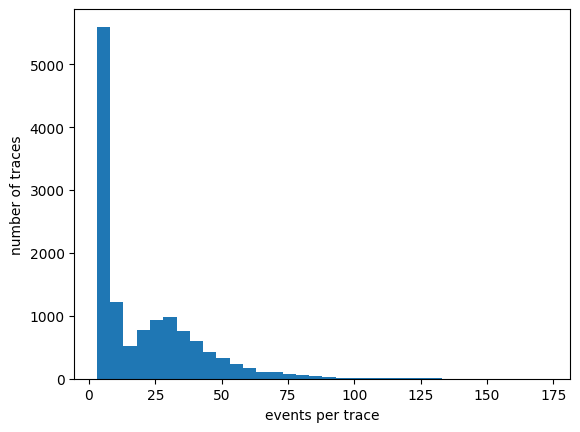

The longest trace contains 175 events. The shortest trace: 3 events.


In [57]:
length = len(log)

#we define the lenght of the longest and the shortes traces in the log in terms of contained events
max_length = 0
min_length = 1000
for trace in log:
    if len(trace) > max_length:
        max_length = len(trace)
        
    if len(trace) < min_length:
        min_length = len(trace)

print(f'The log consists {length} traces. Trace length is distributed as follows:')

#we plot distribution of length frequencies across all traces of the log
trace_lengths = []

for trace in log:
    trace_lengths.append(len(trace))

plt.hist(trace_lengths, bins=range(min_length, max_length, 5))
plt.xlabel('events per trace')
plt.ylabel('number of traces')
plt.show()

print(f'The longest trace contains {max_length} events. The shortest trace: {min_length} events.' )

Next, we can display the case duration. Time-wise short cases prevail in the log, which aligns with the length in terms of events distribution. 

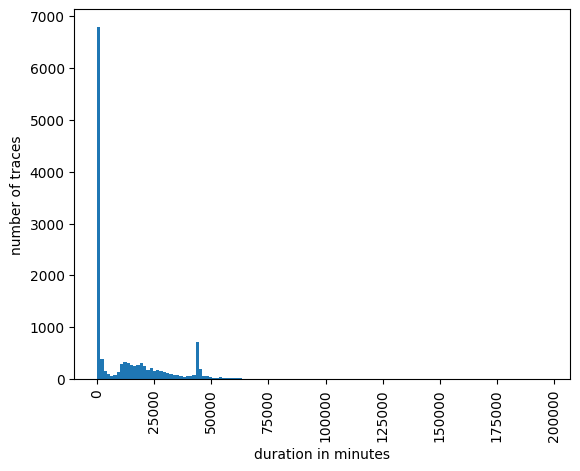

In [58]:
durations = []

for trace in log:
    first_e = trace[0]
    last_e = trace[-1]
    
    t0 = first_e['time:timestamp']
    t1 = last_e['time:timestamp']
    durations.append((t1 - t0).total_seconds()/60)
    
plt.hist(durations, bins=range(0, round(max(durations)), 1440))
ax = plt.gca()
plt.xticks(rotation='vertical')
plt.xlabel('duration in minutes')
plt.ylabel('number of traces')
plt.show()

Now, we want to see what activities are present in the log and what are their lifecycle statges.

In [59]:
activities = set()
event_classes = set()

for trace in log:
    for event in trace:
        activities.add(event['concept:name'])
        event_classes.add((event['concept:name'], event['lifecycle:transition']))


print(f'The log contains {len(activities)} activity types and, considering their lifecycle, {len(event_classes)} event classes.')
for i, e in enumerate(event_classes):
    print(i, e)

The log contains 24 activity types and, considering their lifecycle, 36 event classes.
0 ('W_Completeren aanvraag', 'START')
1 ('W_Afhandelen leads', 'SCHEDULE')
2 ('O_DECLINED', 'COMPLETE')
3 ('W_Nabellen incomplete dossiers', 'SCHEDULE')
4 ('W_Nabellen offertes', 'START')
5 ('W_Valideren aanvraag', 'COMPLETE')
6 ('O_CREATED', 'COMPLETE')
7 ('O_SENT_BACK', 'COMPLETE')
8 ('W_Completeren aanvraag', 'SCHEDULE')
9 ('A_APPROVED', 'COMPLETE')
10 ('W_Afhandelen leads', 'COMPLETE')
11 ('W_Beoordelen fraude', 'START')
12 ('W_Beoordelen fraude', 'COMPLETE')
13 ('W_Nabellen offertes', 'SCHEDULE')
14 ('O_CANCELLED', 'COMPLETE')
15 ('W_Nabellen incomplete dossiers', 'COMPLETE')
16 ('O_SELECTED', 'COMPLETE')
17 ('A_SUBMITTED', 'COMPLETE')
18 ('O_SENT', 'COMPLETE')
19 ('A_FINALIZED', 'COMPLETE')
20 ('W_Valideren aanvraag', 'START')
21 ('W_Wijzigen contractgegevens', 'SCHEDULE')
22 ('W_Completeren aanvraag', 'COMPLETE')
23 ('A_PARTLYSUBMITTED', 'COMPLETE')
24 ('W_Beoordelen fraude', 'SCHEDULE')
25 ('

PM4PY allows for process discovery and plotting. We will plot the Petri net representing the process discovered by the application of algorithm 'inductive miner'. 

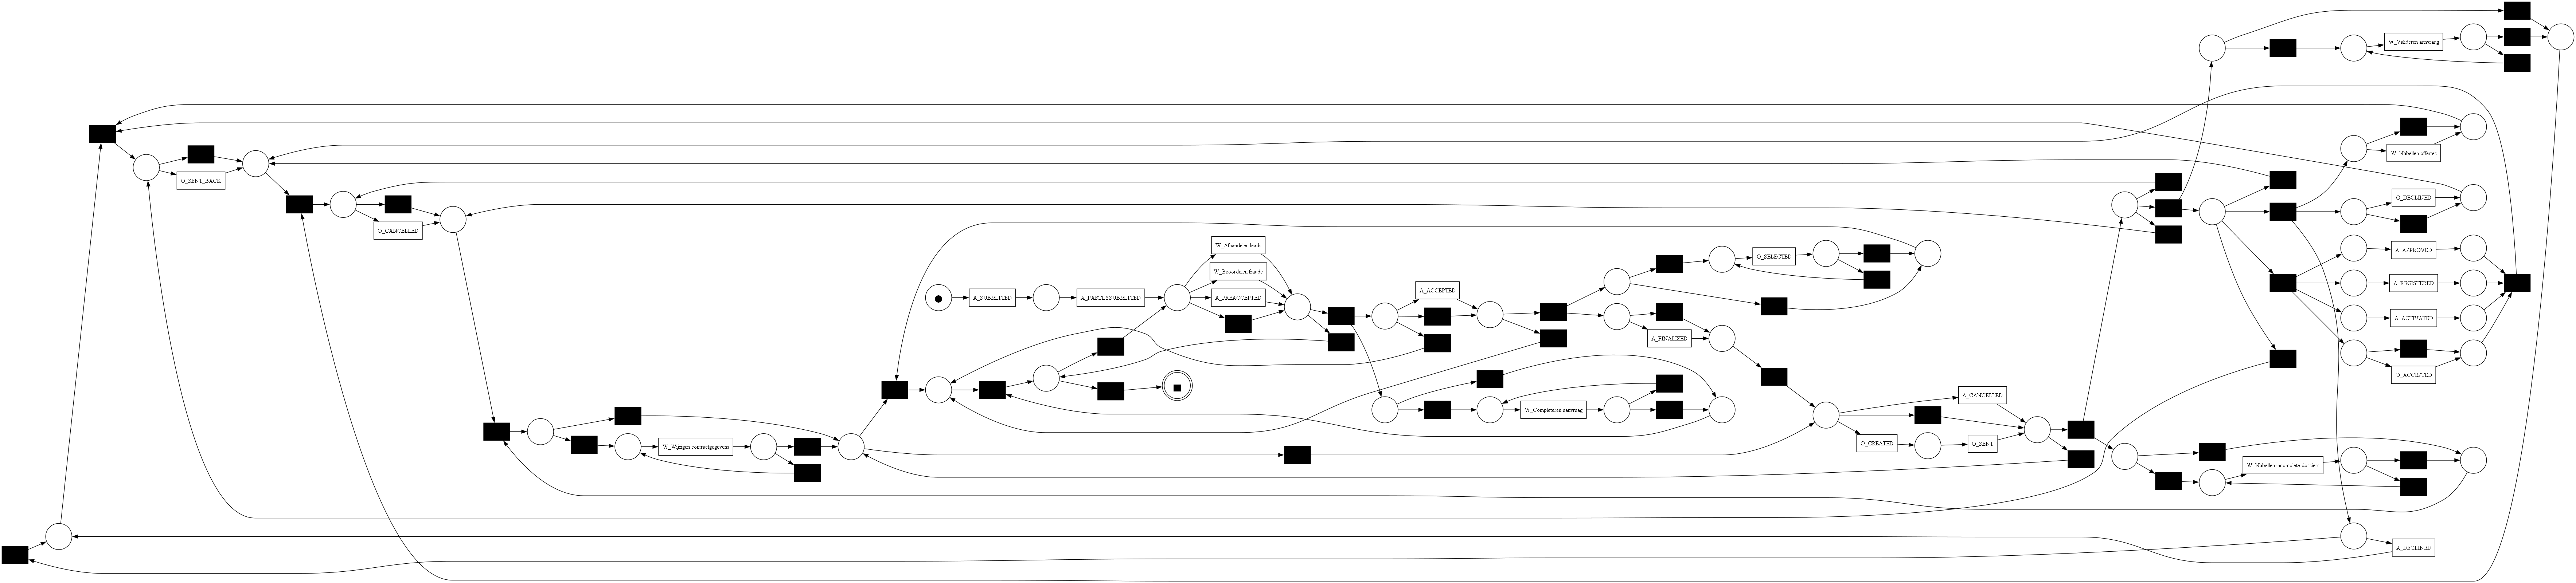

In [60]:
net, im, fm = pm4py.discover_petri_net_inductive(log)
pm4py.view_petri_net(net, im, fm)

For the purposes of SNA we are interested in resources. Let's take a look at their values.

In [61]:
resources = [event['org:resource'] if 'org:resource' in event.keys() else None for trace in log for event in trace]

print(f'All process instances use {len(set(resources))} different resources in total')

for i, r in enumerate(set(resources)):
    print(i, r)

All process instances use 69 different resources in total
0 10609
1 10972
2 11201
3 10138
4 10188
5 112
6 10931
7 10125
8 11181
9 11289
10 11121
11 10914
12 10821
13 10913
14 11179
15 11003
16 11000
17 10789
18 10859
19 10629
20 11189
21 10933
22 11302
23 11180
24 11269
25 10779
26 10935
27 10880
28 10861
29 11202
30 10910
31 10889
32 11300
33 10939
34 10909
35 11259
36 10863
37 11200
38 10809
39 11169
40 11119
41 10881
42 None
43 10982
44 11029
45 11299
46 11319
47 11079
48 11002
49 11304
50 10912
51 10932
52 11203
53 10899
54 11309
55 10862
56 11009
57 11001
58 11254
59 10971
60 10929
61 11339
62 11049
63 11111
64 10228
65 11019
66 11120
67 10124
68 11122


Already in the first few events of the log we saw a NaN value in 'org:resources'. Let's see how significant their share is.

In [62]:
nan_resources = resources.count(None)
share = nan_resources/len(resources)*100

print(f'{nan_resources} events do not have record of resource. It comprises {share:.2f}% of all events.')

18010 events do not have record of resource. It comprises 6.87% of all events.


The share of events with missing value for 'org:resource' is relatively small. We want to see how these values are distributes with regards to the activities to see if there is any pattern. 

In [63]:
#we will put all rows with NaN 'org:resource" values in a separate dataframe
nan_rows = log_df[log_df['org:resource'].isna()]
nan_rows.head()

org:resource lifecycle:transition            concept:name  \
4           NaN                START  W_Completeren aanvraag   
10          NaN             SCHEDULE     W_Nabellen offertes   
11          NaN             COMPLETE  W_Completeren aanvraag   
12          NaN                START     W_Nabellen offertes   
13          NaN             COMPLETE     W_Nabellen offertes   

                     time:timestamp                    case:REG_DATE  \
4  2011-10-01 11:36:46.437000+00:00 2011-10-01 00:38:44.546000+00:00   
10 2011-10-01 11:45:11.554000+00:00 2011-10-01 00:38:44.546000+00:00   
11 2011-10-01 11:45:13.917000+00:00 2011-10-01 00:38:44.546000+00:00   
12 2011-10-01 12:15:41.290000+00:00 2011-10-01 00:38:44.546000+00:00   
13 2011-10-01 12:17:08.924000+00:00 2011-10-01 00:38:44.546000+00:00   

   case:concept:name case:AMOUNT_REQ  
4             173688           20000  
10            173688           20000  
11            173688           20000  
12            173688           20000  
13            173688           20000

In [64]:
#check which activities tend to have NaN values
unique_nan_act = nan_rows['concept:name'].unique()
print(unique_nan_act)

['W_Completeren aanvraag' 'W_Nabellen offertes'
 'W_Nabellen incomplete dossiers' 'W_Valideren aanvraag'
 'W_Afhandelen leads' 'W_Wijzigen contractgegevens' 'W_Beoordelen fraude']


Only certain group of activities contains the rows without 'org:resource'. They all belong to group W, and correspond to: 'W_Complete application', 'W_Tables quotes', 'W_Table incomplete files', 'W_Validate application', 'W_Deal with leads', 'W_Modify contract data', 'W_ Assess fraud'.


On one hand, from the titles we could suppose that those are automated activities and by organization's convention they might not register resource in the logs. On the other hand, we lack infromation to make this assumption with certainty. 

We can check now the oposite relation: how many of these activities lack resource information.

In [65]:
strings_to_match = [
    'W_Completeren aanvraag',
    'W_Nabellen offertes',
    'W_Nabellen incomplete dossiers',
    'W_Valideren aanvraag',
    'W_Afhandelen leads',
    'W_Wijzigen contractgegevens',
    'W_Beoordelen fraude'
]

nan_act = log_df[log_df['concept:name'].isin(strings_to_match)]
unique_res_nan_act = nan_act['org:resource'].unique()

share_nan_act = nan_resources/len(nan_act) *100

print(f'{share_nan_act:.2f}% of mentioned activities lack resource information.')
print(f'Mentioned activities involve {len(unique_res_nan_act)-1} resources.')


10.59% of mentioned activities lack resource information.
Mentioned activities involve 59 resources.


Finding out that these activities lack resource value only in 10% of the cases impedes us from concluding that this lack is a rule. It could be just a data inconsistency, a consequence of system or human error. Information beyond the scope of this event log is requiered to make conclusions.

For the purpose of this submission we will omit the reasons and see how we can handle missing values. The options are the following:
* drop events with missing values (can lead to loss of information)
* impute with the most frequent performer per event class (can skew the degree distribution of the resource network towards the performer)
* impute with an artificial resource 'default_resource' (will also affect the network structure by intrudicung an artificial extra node)
* impute with predictions of machine learning method such as k Nearest Neighbours, Decision Tree or Artificial Neural Network (including Graph Neural Networks) (can give more precise result but is more complex)

Since the share of Nan values is relatively small, for the sake of simplicity we will trimm the log dropping events with missing resource values and expect it not to affect SNA in a drastic way.

In [66]:
#we drop rows with missing values in corresponding column from dataframe and then convert it to log object
log_df = log_df.dropna(subset=['org:resource'])

parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'}
log = log_converter.apply(log_df, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)

## 5. Social Networks Analysis Tools in PM4PY

PM4PY proposes several metric to generate networks from logs. We will use three of them:
* handover of work - subsequence of activities with regard to resource, or who passes work to whom
* working together - two different resources are carrying out activities in the same case
* joint activities - similarity in frequency of specific activities, or who carries out similar activities

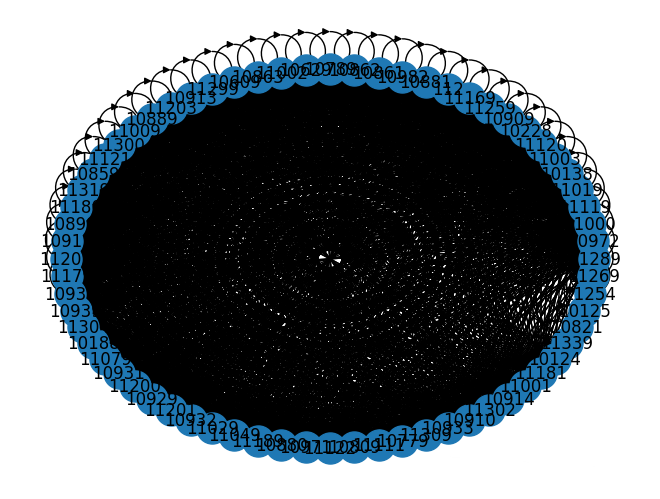

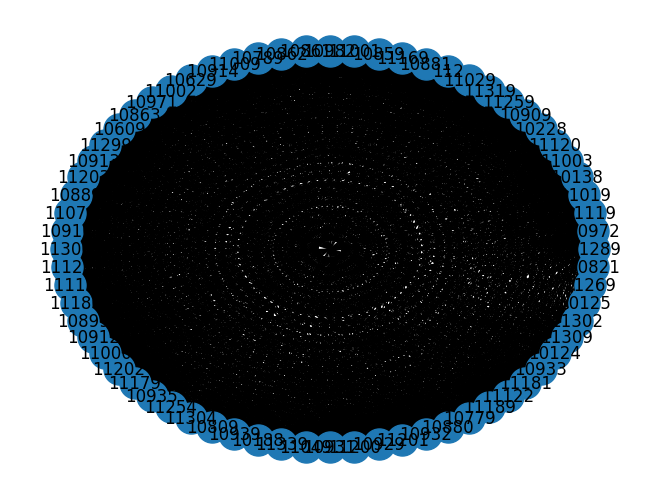

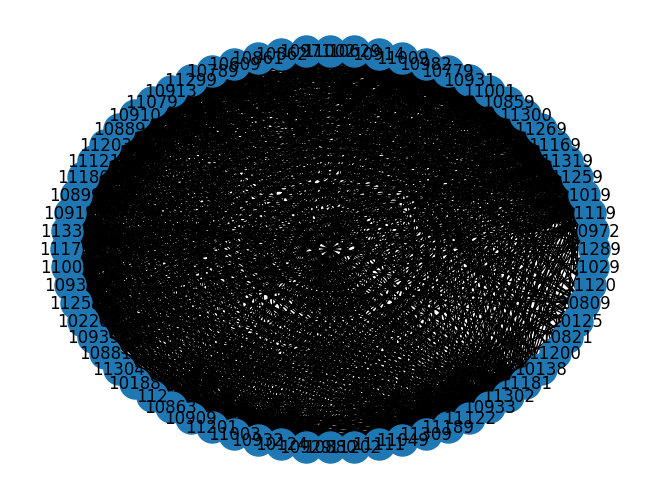

In [67]:
#first, we compute the metrics
hw_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.HANDOVER_LOG)
wt_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.WORKING_TOGETHER_LOG)
ja_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.JOINTACTIVITIES_LOG)

#then visualize them as graphs
gviz_hw = pn_vis.apply(hw_values, variant=pn_vis.Variants.NETWORKX,
                            parameters={pn_vis.Variants.NETWORKX.value.Parameters.FORMAT: "png"})
gviz_wt = pn_vis.apply(wt_values, variant=pn_vis.Variants.NETWORKX,
                            parameters={pn_vis.Variants.NETWORKX.value.Parameters.FORMAT: "png"})
gviz_ja = pn_vis.apply(ja_values, variant=pn_vis.Variants.NETWORKX,
                            parameters={pn_vis.Variants.NETWORKX.value.Parameters.FORMAT: "png"})

pn_vis.view(gviz_hw, variant=pn_vis.Variants.NETWORKX)
pn_vis.view(gviz_wt, variant=pn_vis.Variants.NETWORKX)
pn_vis.view(gviz_ja, variant=pn_vis.Variants.NETWORKX)

The resulting networks visual representation is hard to interpret. We will convert them into NetworkX graphs in order to use this package's tools for visualization and analysis directly. 

In [68]:
#the metrics calculated by PM4PY represent an SNA object which contains a dictionary with edges and their respective weights
print(type(hw_values))
print(hw_values.connections)

<class 'pm4py.objects.org.sna.obj.SNA'>
{('112', '112'): 0.1366879702989576, ('112', '10862'): 0.0003851096697143698, ('112', '10912'): 0.0007745464143693504, ('112', '10939'): 0.0008870503628252337, ('112', '11019'): 0.0004110721193580352, ('112', '11000'): 0.0009909001613998953, ('112', '10913'): 0.0012159080583116618, ('112', '10971'): 0.00033751184536764993, ('112', '11180'): 0.0009822460115186736, ('112', '11169'): 0.0032366520555769506, ('112', '11202'): 0.0010644604353902806, ('112', '11120'): 0.0008957045127064555, ('112', '11001'): 0.00018173714750565766, ('112', '10889'): 0.0010904228850339458, ('112', '11201'): 0.0009692647866968408, ('112', '10188'): 0.00026827864631787557, ('112', '11119'): 0.001462551329926483, ('112', '10809'): 8.221442387160703e-05, ('112', '10779'): 4.759782434671986e-05, ('112', '10863'): 0.0009346481871719537, ('112', '10629'): 0.0003721284448925371, ('112', '10982'): 0.001626980177669697, ('112', '10880'): 0.0006490612410916344, ('112', '11200'): 0.

Note that graphs generated by PM4PY contain selfloops. Whether we keep them or not, depends on the purposes of analysis and particular metric. For example, keeping selfloops with handover of work network can help identify processes where the same individual executes subsequent event more often than hands them over. Depending on process properties, it can be interpreted as negative or positive.

If we are more interested in identifying interactions between nodes even if they do not prevail. In this submission, we will exclude selfnodes grom the resulting networks to concentrate on connections between nodes. 

In [69]:
#we generate NetworkX graphs based on the values
G_hw = pm4py.algo.organizational_mining.sna.util.sna_result_to_nx_graph(hw_values)
G_wt = pm4py.algo.organizational_mining.sna.util.sna_result_to_nx_graph(wt_values)
G_ja = pm4py.algo.organizational_mining.sna.util.sna_result_to_nx_graph(ja_values)

In [70]:
#we add weights as edge attributes
nx.set_edge_attributes(G_hw, hw_values.connections, "weight")
nx.set_edge_attributes(G_wt, wt_values.connections, "weight")
nx.set_edge_attributes(G_ja, ja_values.connections, "weight")


In [71]:
#we exclude selfloops:
def exclude_selfloops(G):
    edges_to_remove = set()
    for u, v in G.edges():
        if u==v:
            edges_to_remove.add((u,v))
    G.remove_edges_from(list(edges_to_remove))
    return G

In [72]:
G_hw = exclude_selfloops(G_hw)
G_wt = exclude_selfloops(G_wt)
G_ja = exclude_selfloops(G_ja)

## 6. Social Network Analysis with NetworkX

Let's explore the graphs with the help of NetworkX package. We will start with handover graph. We will use simple custom functions that plot the graph, and compute and print basic network statistics.

In [73]:
def normalize_edge_weights(G):
    edges = G.edges(data=True)
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1  # make sure we avoid division by zero
    normalized_weights = [weight / max_weight * 10 for weight in weights] #normalize and scale
    return normalized_weights

def plot_network(G):
    #we define node and edge visualization parameters here
    options = {
        'with_labels': True,    
        'node_size': 400,       
        'node_color': 'dodgerblue',    
        'font_size': 8,          
        'width': normalize_edge_weights(G)           # line width of the edges according to its weight
    }

    # size of the plot
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42)   
    nx.draw(G, pos, **options)    # ** unpacks a dictionary into keyword arguments 
    plt.show()

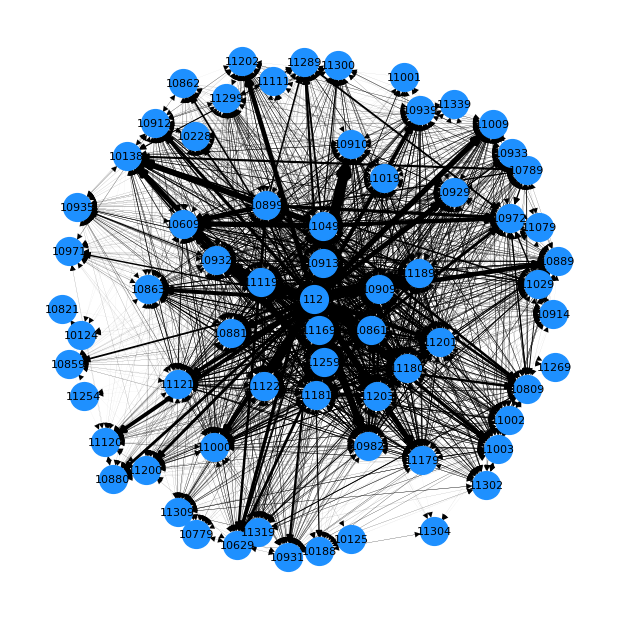

In [74]:
plot_network(G_hw)

In [75]:
#this cell will throw an error: we will see why
def graph_statistics(G):
    density = nx.density(G)
    av_path = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
    av_clustering = nx.average_clustering(G)

    return (f'This is a {"directed" if G.is_directed() else "undirected"} network with {len(G.nodes)} nodes and {len(G.edges)} edges. \nNetworks statistics: \nDensity: {density:.3f} \nAverage shortest path: {av_path:.3f} \nDiameter: {diameter} \nAverage clustering coefficient: {av_clustering:.3f}')

print(graph_statistics(G_hw))

This is a directed network with 68 nodes and 2599 edges. 
Networks statistics: 
Density: 0.570 
Average shortest path: 1.455 
Diameter: 3 
Average clustering coefficient: 0.829


We have a moderate connected network (social networks tend to be rather sparse then dense) with small diamter and high clustering coefficient (expected from social networks).

Now we are going to apply modularity-based algorithms to detect communities in the network. Modularity is a measure that shows how strongly the nodes are connected within the cluster in comparison with connections between clusters. Before applying algorithms, we are going to define a baseline for modularity. Let's assume the baselin is when each node is assigned to its own separate community.

In [76]:
def baseline_modularity(G):
    part_baseline = []
    for n in G.nodes():
        part_baseline.append({n})
    return nx.community.modularity(G,part_baseline)

In [77]:
print(f'Baseline partition: \neach node is its own community ({len(G_hw.nodes())} partitions). \nBaseline modularity: {baseline_modularity(G_hw)}')

Baseline partition: 
each node is its own community (68 partitions). 
Baseline modularity: -0.02451431002176087


Our baseline partition is slightly below zero, which can interpreted like partition quality slightly worse than random. 


The first algorithm we will apply is Greedy Modularity Maximization that merges nodes iteratively until no modularity improvement can be achieved.


The Louvain algorithm also aims to increase modularity but also to decrease the complexity of the greedy modularity algorithm: the nodes are moved between communites until modularity gain is maximized, and then are mapped to a single node to continue optimization on global level.

 
There are other approached to community detection, for example Girvan-Newman algorithm, but it requieres a number of communities we expect to find as input. We are interested in seeing how many communities can be detected without other input than the network. 

In [78]:
# we define ahelper function to get an identifier for a community for plotting later on
def community_idx(communities,x): 
    for i in range(len(communities)):
        if x in communities[i]:
            return i

In [79]:
#we transform the output of NetworkX greedy modularity algorithm from frozen set to regular set of partitions
def greedy_modularity_community_detection(G):
    communities = nx.community.greedy_modularity_communities(G, weight = 'weight')
    partition = [set(community) for community in communities]
    return partition

#we define a function which will aply both algorithms and plot graphs with partitions in different colours
def community_search(G):
    part_louvain = sorted(nx.community.louvain_communities(G, seed = 42), key=len, reverse=True)
    part_greedy = sorted(greedy_modularity_community_detection(G), key=len, reverse=True)
    print(f'Louvain algorithm has detected {len(part_louvain)} communities, with partitions: {part_louvain}')
    print(f'The largest comminuty consists of {len(part_louvain[0])} nodes, the smallest - {len(part_louvain[-1])}')
    print(f'modularity:{nx.community.modularity(G,part_louvain):.3f}')
    print(f'Greedy modularity algorithm has detected {len(part_greedy)} communities, with partitions:{part_greedy}')
    print(f'The largest comminuty consists of {len(part_greedy[0])} nodes, the smallest - {len(part_greedy[-1])}')
    print(f'modularity:{nx.community.modularity(G,part_greedy):.3f}')
    
    options_l = {
        'with_labels': True,               # draw labels
        'node_size': 400,                  # size of the nodes (fixed or array)
        'node_color': [community_idx(part_louvain, v) for v in G.nodes],  # color of the nodes (based on partition)
        'font_size': 8,                    # font size for labels
        'width': normalize_edge_weights(G),             # line width of the edges 
        'pos': nx.spring_layout(G, seed=42)
    }

    options_gr = {
        'with_labels': True,               # draw labels
        'node_size': 400,                  # size of the nodes (fixed or array)
        'node_color': [community_idx(part_greedy, v) for v in G.nodes],  # color of the nodes (based on partition)
        'font_size': 8,                    # font size for labels
        'width': normalize_edge_weights(G),             # line width of the edges
        'pos': nx.spring_layout(G, seed=42)
    }

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    pos = nx.spring_layout(G, seed=42)   

    # Draw the first graph in the first subplot
    nx.draw(G, ax=axes[0], **options_l)
    axes[0].set_title("Louvain community detection")

    # Draw the second graph in the second subplot
    nx.draw(G, ax=axes[1], **options_gr)
    axes[1].set_title("Greedy modularity community detection")

    # Display the plots
    plt.tight_layout
    plt.show()
    

Louvain algorithm has detected 3 communities, with partitions: [{'11201', '11300', '10909', '10863', '11181', '11319', '11119', '11299', '10881', '11002', '10914', '10912', '11203', '11309', '10913', '11179', '11003', '11000', '10933', '11302', '11180', '11019', '10935', '10861', '11121', '11122'}, {'11202', '10910', '10889', '10188', '10931', '112', '10939', '11200', '11169', '10982', '10932', '10880', '10862', '10859', '11009', '11189', '11001', '11254', '10971', '10929', '11304', '11111', '10228', '11120', '10124'}, {'10609', '10972', '10138', '11259', '11289', '10125', '10809', '11029', '11079', '10821', '10899', '10789', '10629', '11339', '11269', '10779', '11049'}]
The largest comminuty consists of 26 nodes, the smallest - 17
modularity:0.157
Greedy modularity algorithm has detected 3 communities, with partitions:[{'11202', '10910', '10889', '10188', '10931', '112', '10939', '11200', '10863', '11169', '10861', '10982', '11304', '10932', '10862', '10859', '11009', '11189', '11001'

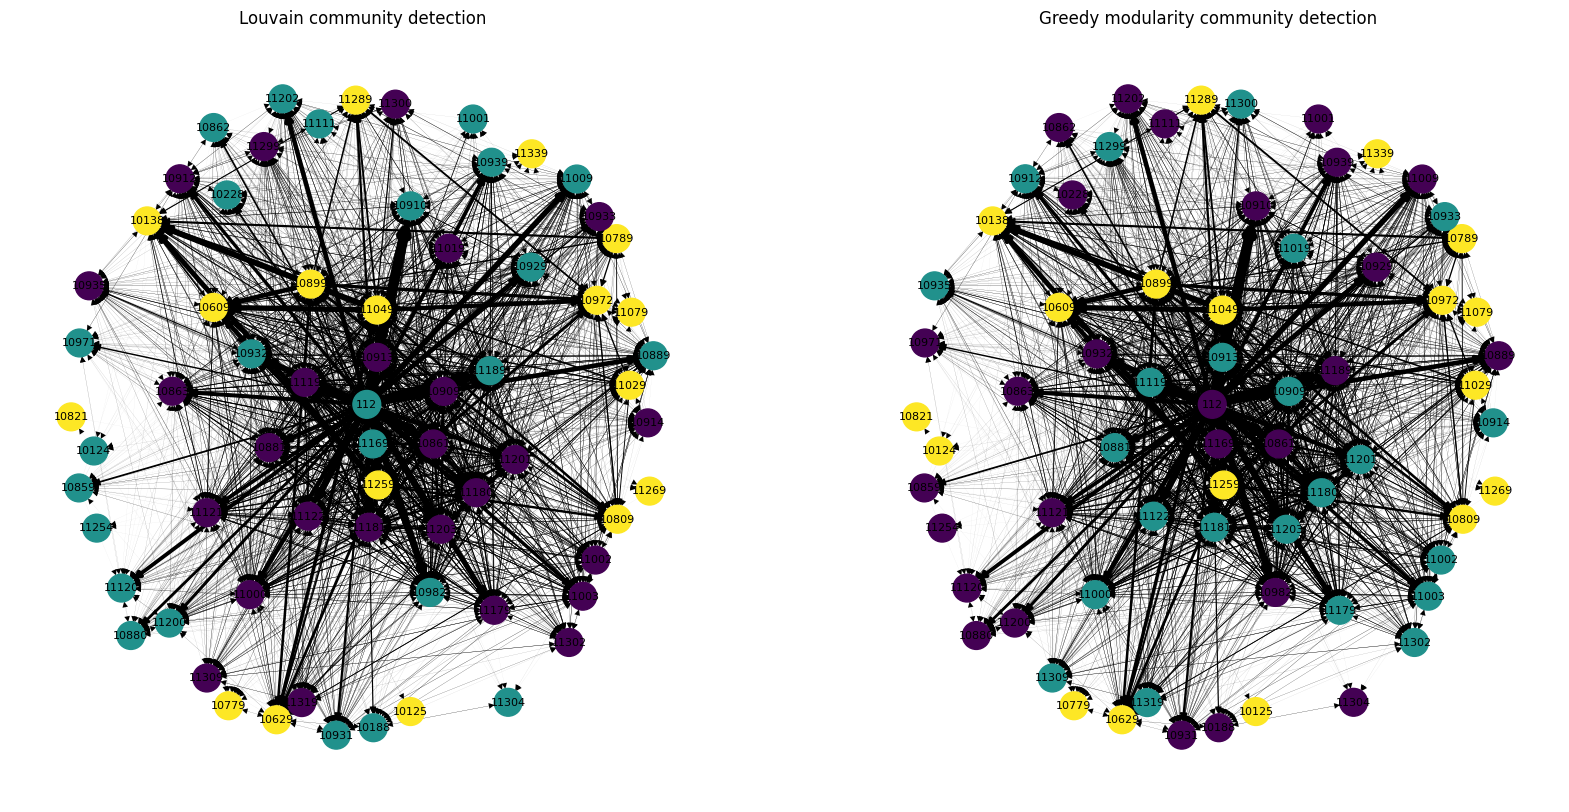

In [80]:
community_search(G_hw)

We can see that both algorithms give a very close result, detecting 3 communities. Positive modularity indicates that partitions are better than random, although the value is not particularly high. Louvain algorithm performs somewhat better than greedy modularity. 



Let's take a look at networks generated by other SNA metric of the process log.

Work together:

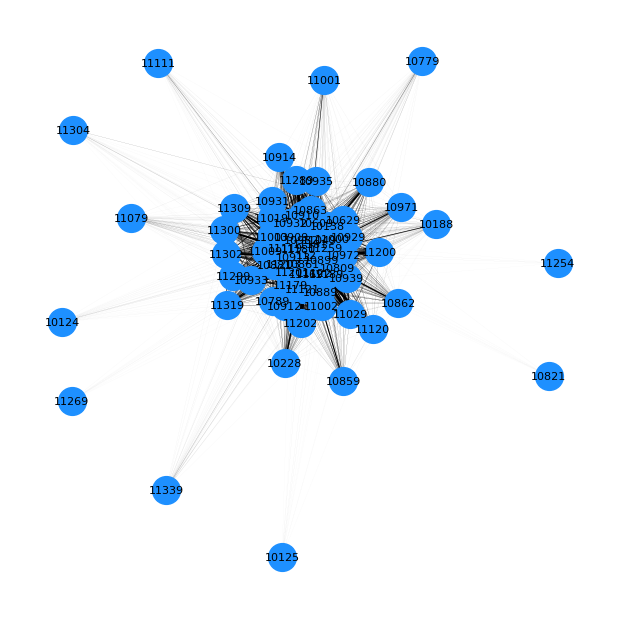

In [81]:
plot_network(G_wt)


In [82]:
print(graph_statistics(G_wt))


This is a undirected network with 68 nodes and 1795 edges. 
Networks statistics: 
Density: 0.788 
Average shortest path: 1.212 
Diameter: 2 
Average clustering coefficient: 0.920


This network is even more denser and has a shorter diameter than the handover of work network. We would expect to see fewer clusters or/and clusters with high modularity.

In [83]:
print(f'Baseline partition: \neach node is its own community ({len(G_wt.nodes())} partitions). \nBaseline modularity: {baseline_modularity(G_wt)}')

Baseline partition: 
each node is its own community (68 partitions). 
Baseline modularity: -0.03430097993272198


Louvain algorithm has detected 3 communities, with partitions: [{'11201', '10188', '112', '11181', '10914', '10913', '11179', '10859', '11189', '11269', '11180', '10880', '10861', '11202', '10910', '10889', '10939', '10909', '10863', '11169', '11119', '10881', '10982', '11203', '10862', '11001', '11254', '10971', '11304', '11111', '10228', '11121', '11120'}, {'10972', '10609', '10138', '10931', '11259', '11200', '11289', '10125', '10809', '11029', '11079', '11002', '10821', '10932', '10899', '11000', '10789', '10629', '10929', '10779', '11049'}, {'11309', '11003', '11300', '10933', '11009', '11302', '11339', '11319', '11299', '10935', '11019', '10124', '10912', '11122'}]
The largest comminuty consists of 33 nodes, the smallest - 14
modularity:0.032
Greedy modularity algorithm has detected 3 communities, with partitions:[{'11201', '112', '11181', '11121', '10914', '10913', '11179', '11003', '11000', '10859', '11189', '11180', '11269', '10880', '10861', '11202', '10910', '10889', '10939'

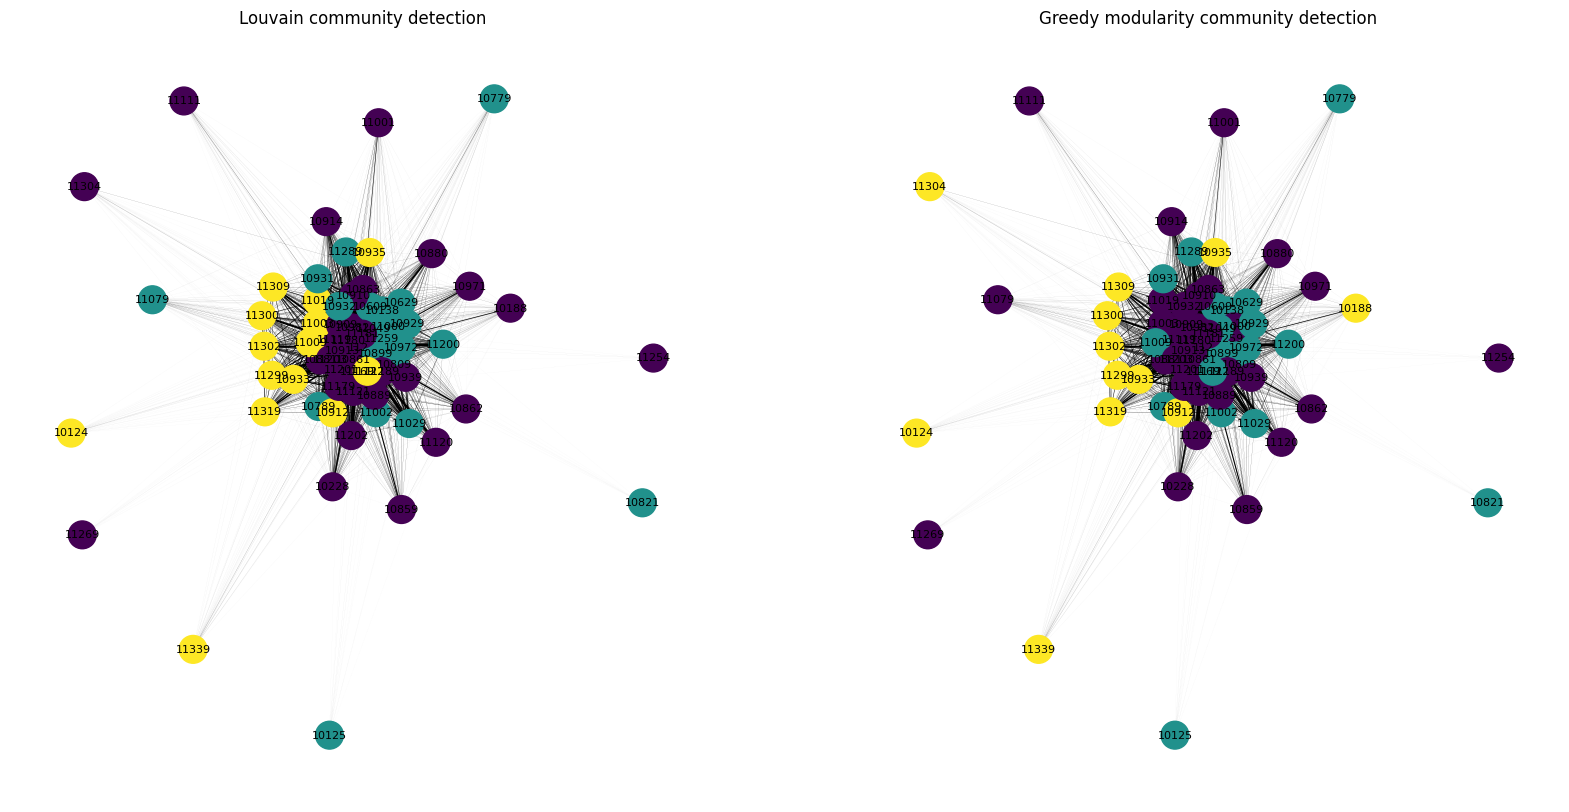

In [84]:
community_search(G_wt)

Surprisingly, the best partition found by the algorithms is almos as good as random. We could suggest, that, besides few outliers, most of the resources work together in most of the cases, thus forming 1 big community which, due to the outliers, couldn't be found.

Joint activities:

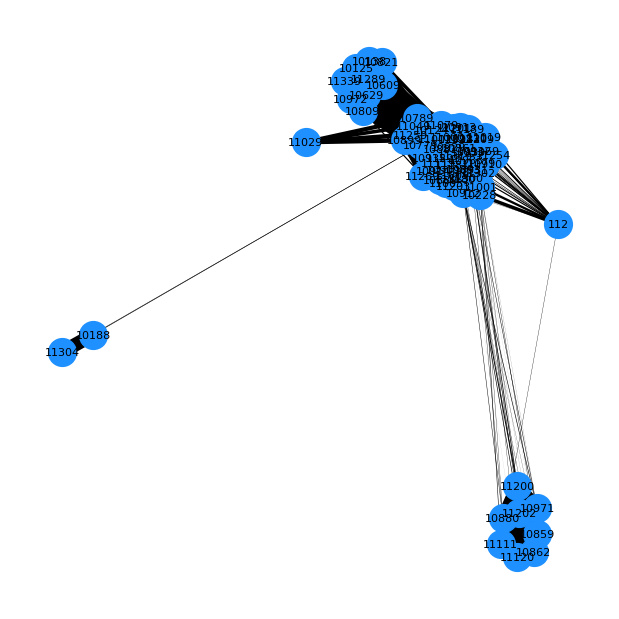

In [85]:
plot_network(G_ja)

In [86]:
print(graph_statistics(G_ja))

This is a undirected network with 68 nodes and 1286 edges. 
Networks statistics: 
Density: 0.565 
Average shortest path: 1.476 
Diameter: 3 
Average clustering coefficient: 0.911


In [87]:
print(f'Baseline partition: \neach node is its own community ({len(G_ja.nodes())} partitions). \nBaseline modularity: {baseline_modularity(G_ja)}')

Baseline partition: 
each node is its own community (68 partitions). 
Baseline modularity: -0.01864025889335295


Louvain algorithm has detected 4 communities, with partitions: [{'11201', '10931', '112', '11181', '11121', '10914', '10913', '11179', '11003', '11000', '10933', '11189', '11302', '11180', '11269', '10935', '10861', '10910', '10889', '11300', '10939', '10909', '10863', '11169', '11119', '11299', '10982', '11319', '10881', '11079', '11002', '10912', '10932', '11203', '11309', '11009', '11001', '11254', '10929', '10228', '11019', '11122'}, {'10609', '10972', '10138', '11259', '11289', '10125', '10809', '11029', '10821', '10899', '10789', '10629', '11339', '10779', '11049', '10124'}, {'11202', '10862', '10859', '11200', '10971', '10880', '11111', '11120'}, {'11304', '10188'}]
The largest comminuty consists of 42 nodes, the smallest - 2
modularity:0.160
Greedy modularity algorithm has detected 4 communities, with partitions:[{'11201', '10931', '112', '11181', '11121', '10914', '10913', '11179', '11003', '11000', '10933', '11189', '11302', '11269', '11180', '10935', '10861', '10910', '10889

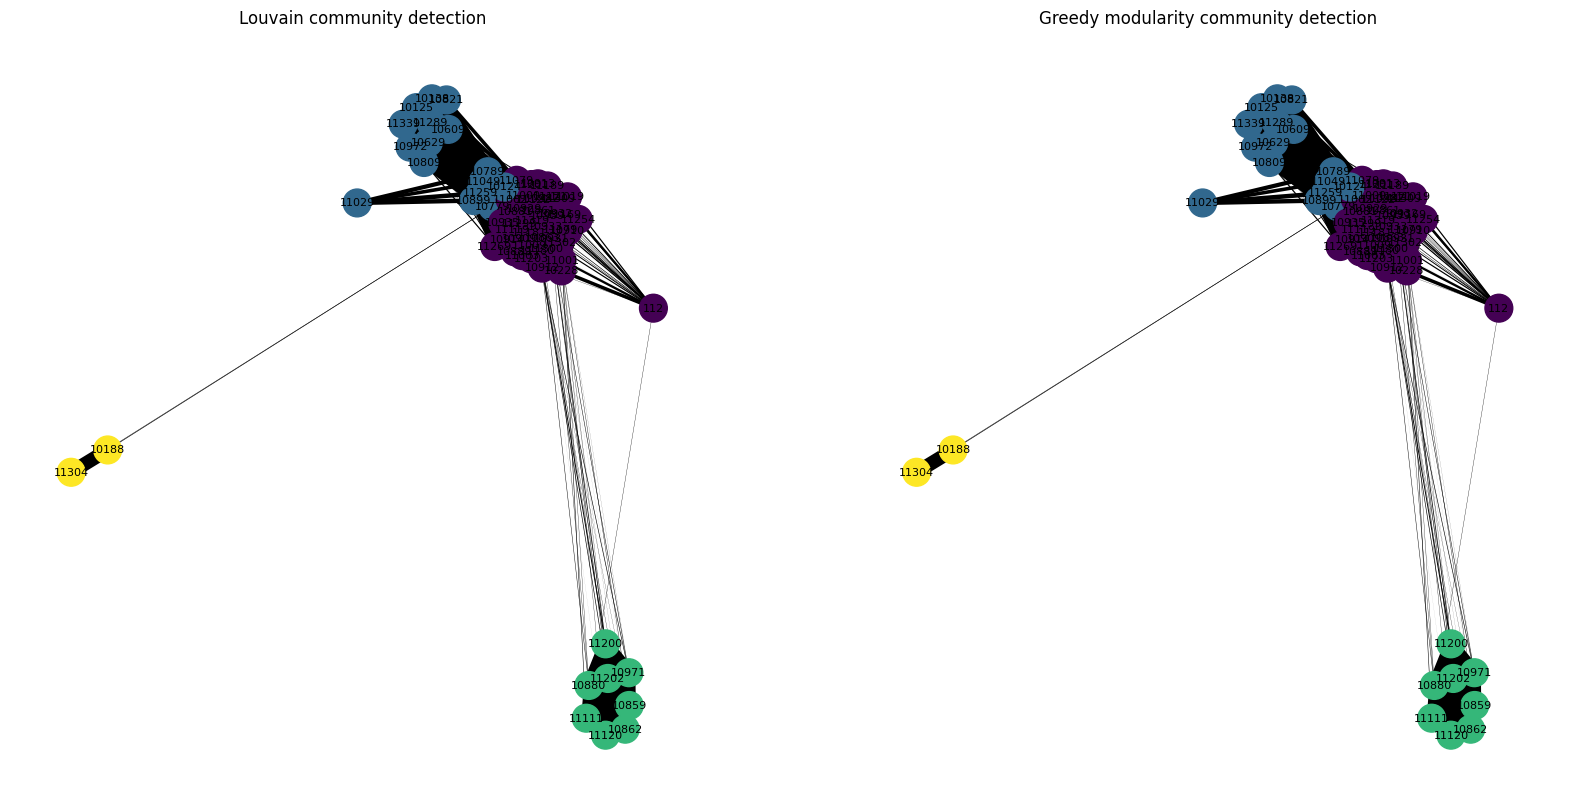

In [88]:
community_search(G_ja)

The performance of both algorithms is identical. Modularity is positive and almost as good as with the network generated by handover of work metric. Graphically, 4 groups of resources carrying out the same activities, seems distinctive, although two communities (blue and purple) are adjacent.

## 7. Clustering with DBSCAN

Apart from network science algorithms, we will also apply an unsupervised Machine Learning clustering technique. DBSCAN is a density-based clustering approach. As well as the network algorithms applied above, it doesn't requiere a specification of the number of cluster as a parameter. It will be interesting to find clusters in the network generated by joint activities.

First, we are going to embed the nodes of the network with the help of node2vex library.

In [89]:
from node2vec import Node2Vec
#dimensions, walk_length and num_walks are assigned as best of several random attempts
node2vec = Node2Vec(G_ja, dimensions=64, walk_length=20, num_walks=10,workers=4,seed=42)
model = node2vec.fit(window=10, min_count=1)

#line commented out since the embedding file is attached
#model.wv.save_word2vec_format("embedding_G_ja.emb") 

#as an example, we will see an embedding of node 11000
embeddings = {node: model.wv[node] for node in G_ja.nodes()}
print("Embedding for Node 0:", embeddings['11000'])

Computing transition probabilities: 100%|██████████| 68/68 [00:00<00:00, 153.00it/s]


Embedding for Node 0: [ 0.17954029 -0.08085407  0.14846735  0.06052921 -0.05044337 -0.25879565
  0.18644318  0.05702505 -0.22149004  0.05519293  0.2460927  -0.25304347
 -0.09595699 -0.08372552  0.06906629  0.26826993  0.10211907 -0.11233719
  0.01976092  0.2815632   0.1666372   0.18058096  0.1356443  -0.03892428
 -0.08935449  0.10296095 -0.23776282  0.07636988 -0.06780784 -0.01416264
 -0.02377081  0.1294119  -0.25979608 -0.37183207 -0.09470548 -0.05804744
  0.05814372  0.07998872  0.3046056   0.01064191 -0.06272189 -0.04235632
  0.09282238 -0.08304057  0.10701659 -0.04024571 -0.01920945 -0.15386267
  0.13542229  0.34573713 -0.02360183 -0.05247136  0.08357439  0.22422208
  0.2806457   0.19157937  0.06975019 -0.03599139 -0.12097441  0.0734842
  0.1519496  -0.19257098  0.04395754  0.08313448]


In [90]:

X = np.loadtxt("embedding_G_ja.emb", skiprows=1) # load the embedding of the nodes of the graph

To define hyperparameters of DBSCAN algorythm, we will plot sorted distance of every embedded node to its k-th nearest neighbor.

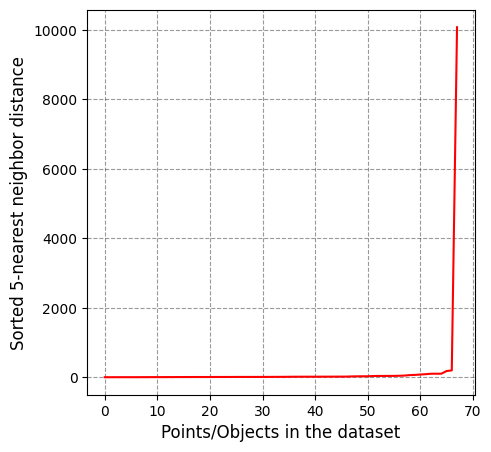

In [91]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    #we compute distances to its k-nearest neighbors for each node
    distances, indices = nbrs.kneighbors(X)                                
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    #we plot the dependancy to see the "knee"
    plt.figure(figsize=(5,5))
    plt.plot(distances, color = 'red')
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * X.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=X, k=5)

Now, let's run the DBSCAN algorithm. the quality metric will be the silhouette coefficient, which measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [92]:
db = DBSCAN(eps=400, min_samples=5).fit(X)
labels = db.labels_

#Number of clusters and number of noise (object that do not belong to any cluster)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

Estimated number of clusters: 1
Estimated number of noise points: 1
Silhouette Coefficient: 0.958


Interestingly, a density-based algorithm clusters all nodes to 1 community with the exception with one node for the network which was divided into 4 clusters by both netwok science algorithms. Nevertheless, it is important to take into account that different parameters of embedding can affect the results of the clustering.

## 8. Conclusion

As we could see, process mining allows to extract from the logs valueble information to define resource social network structure, and social networks have a big potential in business process optimization. 


SNA allows to companies and scientists to study the team's behaviour and interactions, check if these processes comply with organizational structure, adapt or retrain accordingly for efficiency maximization.


Social networks can be enhenced with time data from the logs and help identify bottlenecks in the processes from the perspective of resource performance. It can be useful to run simulations and assess resource reallocation strategies.


Incorporating data from social media (for example, LinkedIn) could add another dimensions to organization structure. Companies could use it to find the most influential employees, run (innovation) spread simulations and identify potential leaders for change management.


SNA approach can also be applied at mezo-level: not between single resources, but between departments, and at macro-level: between cpmanies and other players. It could help gain insights about the connections and interactions between companies, suppliers and sutomers and make the business model more robust. 



We have seen only one task and a small fraction of available methods. AI can offer many other Machine Learning and Deep learning approaches to solve such problems as clustering, link prediction, graph classification and simulations. 